* This project tried to understand the current progress of autonomous driving
* The data records disengagement from Dec 2018 to Nov 2019

</br>

* Throughout the data, we tried to look at the average distance between each disengagement (auto drive testing) in order to understand the AD persistancy of each manufacturer.

* Source: the 2019 autonomous mileage reports in DMV website: </br>
https://www.dmv.ca.gov/portal/dmv/detail/vr/autonomous/disengagement_report_2019

In [0]:
#@title Setup
%config InlineBackend.figure_format = 'retina'
import math
import pandas as pd
import numpy as np
from numpy import inf
from progressbar import progressbar
import scipy.stats
import statsmodels.stats.power as power
from functools import partial
import matplotlib.pyplot as plt

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})

#Google Drive Mount
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [0]:
#path="/content/drive/My Drive/2019AutonomousMileageReports.csv"
path = "https://www.dmv.ca.gov/portal/wcm/connect/97c8391d-0cef-4d3e-8acd-0ded876fd364/2019AutonomousMileageReports.csv?MOD=AJPERES&CVID="
auto = pd.read_csv(path)

In [91]:
auto.columns  #Display the variables in the report

Index(['Manufacturer', 'Permit Number', 'VIN NUMBER',
       'Annual Total of Disengagements', '18-Dec', '19-Jan', '19-Feb',
       '19-Mar', '19-Apr', '19-May', '19-Jun', '19-Jul', '19-Aug', '19-Sep',
       '19-Oct', '19-Nov', 'ANNUAL TOTAL'],
      dtype='object')

In [0]:
auto.Manufacturer.unique()  #A list of the manufacturers

array(['AImotive Inc.', 'Apple Inc.', 'Aurora Innovation, Inc.',
       'AutoX Technologies, Inc.', 'Baidu USA LLC',
       'BMW of North America', 'CRUISE LLC', 'Drive.ai Inc', 'Lyft',
       'Mercedes0Benz Research & Development North America, Inc.',
       'Nissan North America, Inc', 'Nullmax', 'Nuro', 'NVIDIA',
       'Phantom AI, Inc. ', 'PlusAI, Inc.', 'PONY.AI, INC.',
       'Qualcomm Technologies, Inc.', 'SAIC Innovation Center',
       'SF Motors, Inc.', 'Telenav, Inc.', 'Tesla, Inc.',
       'Toyota Research Institute', 'Udelv, Inc',
       'Valeo North America Inc.', 'Waymo LLC', 'WeRide Corp',
       'Zoox, Inc'], dtype=object)

In [113]:
auto[auto['Manufacturer'] == 'Baidu USA LLC']

,Manufacturer,Permit Number,VIN NUMBER,Annual Total of Disengagements,18-Dec,19-Jan,19-Feb,19-Mar,19-Apr,19-May,19-Jun,19-Jul,19-Aug,19-Sep,19-Oct,19-Nov,ANNUAL TOTAL
87,Baidu USA LLC,AVT015,3LN6L2LU4GR629715,1,0.0,0.0,0.0,0.0,0.0,877.1,2771.8,4109.2,2929.3,5314.2,6295.2,5570.6,27867.4
88,Baidu USA LLC,AVT015,3LN6L2LU5GR607996,1,3.9,0.0,0.0,18.6,14.5,19.2,0.4,0.0,0.0,0.0,0.0,0.0,56.6
89,Baidu USA LLC,AVT015,3LN6L5LU1HR627987,2,606.1,920.0,923.5,1384.3,1694.5,3572.1,3425.5,4198.5,5694.6,4537.0,5573.5,4116.4,36646.0
90,Baidu USA LLC,AVT015,3LN6L5LU2HR615153,2,1446.7,1934.5,2126.5,2178.1,3041.4,4314.4,2389.4,4838.7,4390.6,6117.3,5940.0,5012.6,43730.2


In [114]:
auto[auto.Manufacturer == 'Tesla, Inc.' ]

,Manufacturer,Permit Number,VIN NUMBER,Annual Total of Disengagements,18-Dec,19-Jan,19-Feb,19-Mar,19-Apr,19-May,19-Jun,19-Jul,19-Aug,19-Sep,19-Oct,19-Nov,ANNUAL TOTAL
452,"Tesla, Inc.",AVT005,5YJ3E1EB0JF086296,0,0.0,0.0,0.0,0.0,12.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.2


In [0]:
data = auto.groupby('Manufacturer')['Annual Total of Disengagements','ANNUAL TOTAL'].sum().reset_index()
data.columns = ['Manufacturer','Number of Diseng','2019 Total']

In [120]:
data['Avg Dist b/w Diseng'] = round(data['2019 Total']/data['Number of Diseng'])
data['2019 Total'] = round(data['2019 Total'])
data.head()

,Manufacturer,Number of Diseng,2019 Total,Avg Dist b/w Diseng
0,AImotive Inc.,26,6056.0,233.0
1,Apple Inc.,64,7544.0,118.0
2,"Aurora Innovation, Inc.",141,13429.0,95.0
3,"AutoX Technologies, Inc.",3,32054.0,10685.0
4,BMW of North America,8,21.0,3.0


In [0]:
with pd.option_context('mode.use_inf_as_null', True):
  data = data.sort_values('Avg Dist b/w Diseng', ascending=False, na_position='last')


In [0]:
data = data.replace(inf, 0).reset_index()

In [0]:
del data['index']

In [127]:
data

,Manufacturer,Number of Diseng,2019 Total,Avg Dist b/w Diseng
0,Baidu USA LLC,6,108300.0,18050.0
1,Waymo LLC,110,1454137.0,13219.0
2,CRUISE LLC,68,831040.0,12221.0
3,"AutoX Technologies, Inc.",3,32054.0,10685.0
4,"PONY.AI, INC.",27,174845.0,6476.0
5,Nuro,34,68762.0,2022.0
6,"Zoox, Inc",42,67015.0,1596.0
7,"PlusAI, Inc.",2,1880.0,940.0
8,AImotive Inc.,26,6056.0,233.0
9,WeRide Corp,39,5917.0,152.0


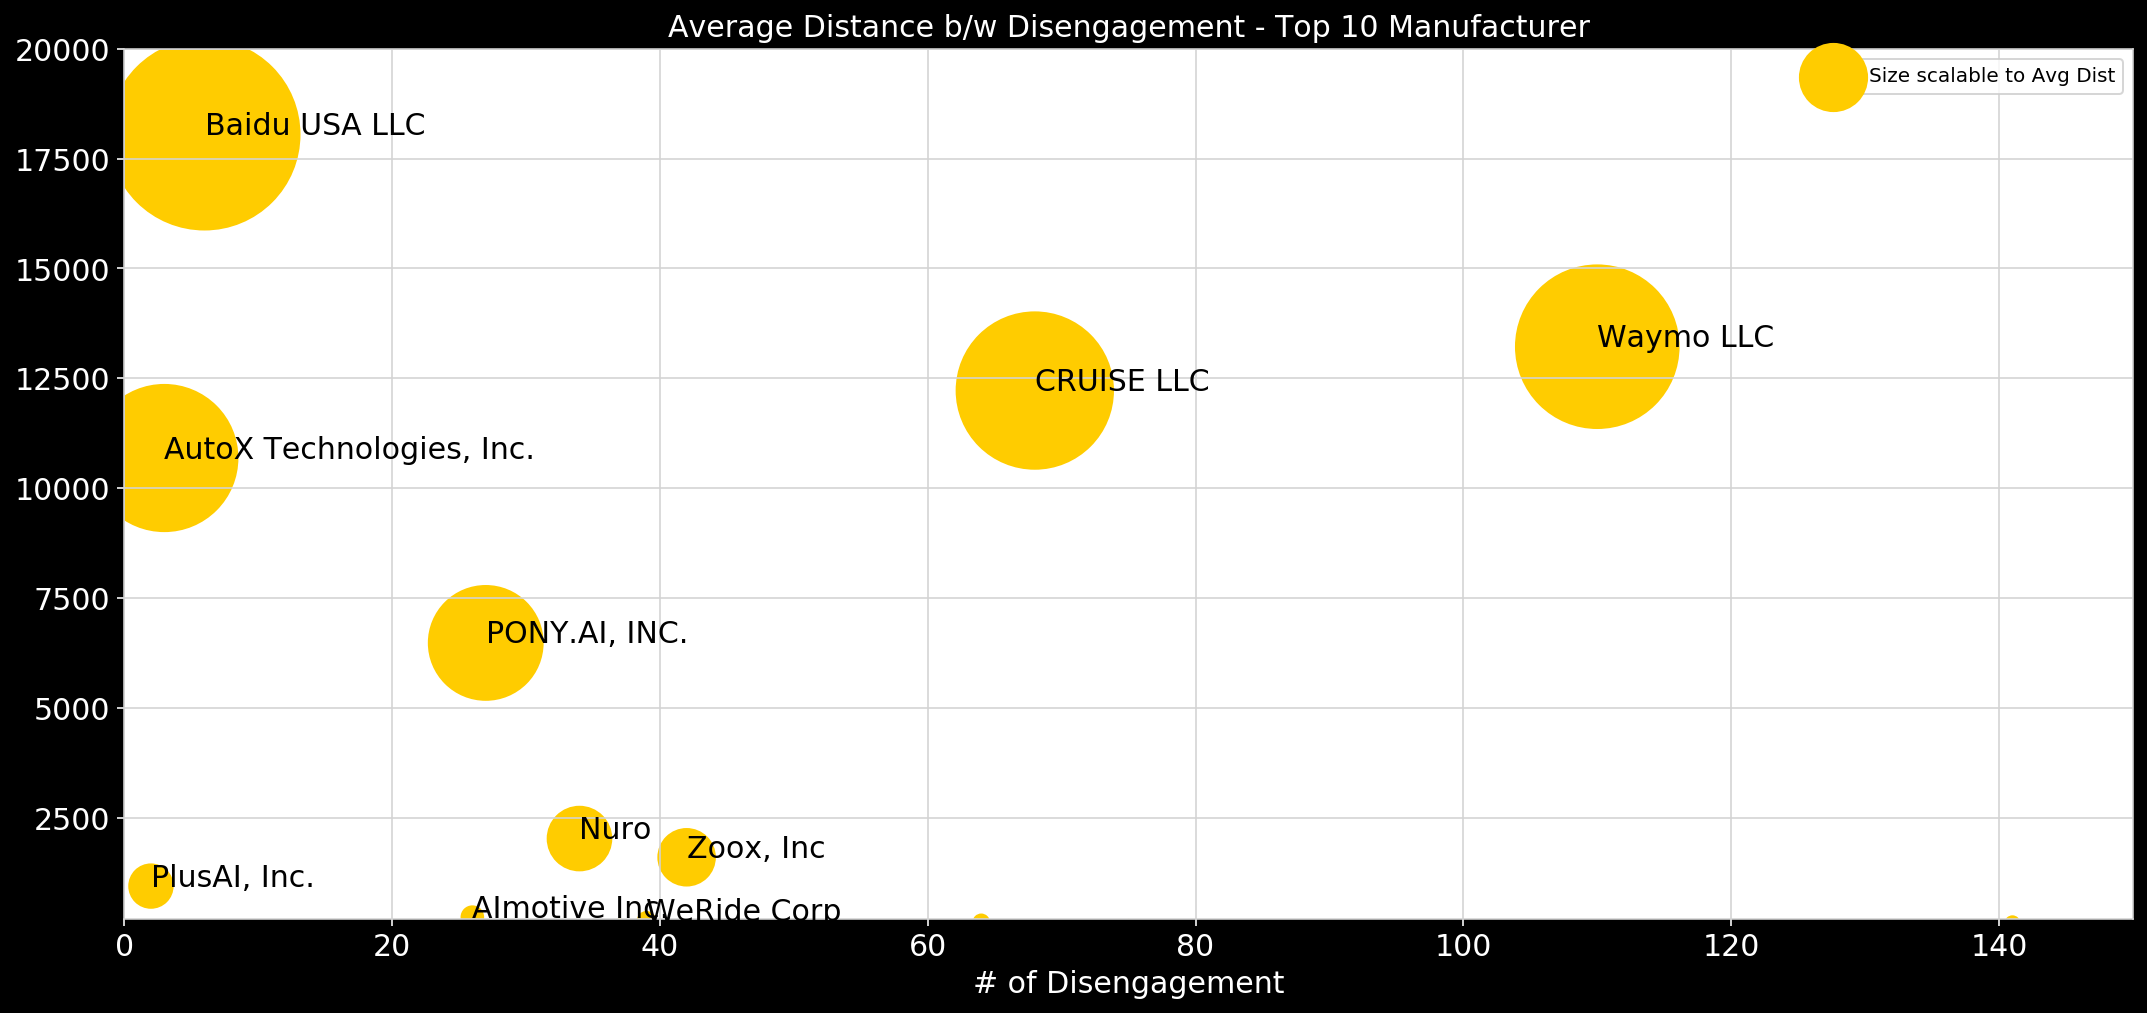

In [147]:
plt.figure(figsize=(18, 8))
plt.axis([0,150,200,20000])
plt.scatter(data['Number of Diseng'], data['Avg Dist b/w Diseng'],color="#FFCC00", 
            s=data['Avg Dist b/w Diseng'].values/2, )
for i in range(10):
  plt.text(data['Number of Diseng'][i], data['Avg Dist b/w Diseng'][i], data['Manufacturer'][i], fontsize=15)

plt.xlabel("# of Disengagement", fontsize=15, color='white')
#plt.xticks(rotation=90)
plt.tick_params(labelsize=15)
plt.legend(['Size scalable to Avg Dist'],markerscale=0.5)
plt.title("Average Distance b/w Disengagement - Top 10 Manufacturer", fontsize=15, color='white')
plt.grid()
plt.show()

- By showing the top 10 average distance per disengagement, we are aware that the leading companies include Baidu, Waymo, Cruise and AutoX. We notice that Baidu is having the longest average distance. Having said so, it's still early to conclude that they have the most consistent and persistant auto-driving experiment. This is because their number of disengagement (6) is still significantly less than Waymo (110) and Cruise (68). This also applies to AutoX since they only had 3 disengagment in last 12 months. So it could simply mean Baidu and AutoX are just "luckier" than the other companies since they are still the late comers of the game. The close analogy is like the case that late comers in the casino often tend to win more games than to lose compared with those who have stayed longer. Therefore further observations in 2020 is necessary to conclude which company is actually the most reliable in terms of auto-driving tests.